# Getting the necessary data

You will need to do this only once

In [1]:
!rm -rf centro.vcf.gz 2>/dev/null
!rm -rf standard.vcf.gz 2>/dev/null
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:1-200000 |bgzip -c > centro.vcf.gz
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:21000000-21200000 |bgzip -c > standard.vcf.gz       
!tabix -p vcf centro.vcf.gz
!tabix -p vcf standard.vcf.gz

# Recipe

In [1]:
from collections import defaultdict
import functools

import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import vcf

### 1. plotting the distribution of variants across the genome in both files
For both files, we will compute windowed statistics. We will divide our file, which includes 200,000 bp of data, in windows of size 2,000 (100 windows). Every time we find a biallelic SNP, we will add a one to the list related to this window in the window function.

The window function will take a VCF record (a SNP, rec.is_snp, that is not biallelic len (rec.ALT) == 1), determine the window where that record belongs (by performing an integer division of rec.POS by size), and extend the list of results of that window by the function passed to it as the fun parameter (which, in our case, is just a one).

So, now we have a list of 100 elements (each representing 2,000 base pairs). Each element will be another list that will have a one for each biallelic SNP found.

So, if you have 200 SNPs in the first 2,000 base pairs, the first element of the list will have 200 ones.

In [2]:
def do_window(recs, size, fun):
    start = None
    win_res = []
    for rec in recs:
        if not rec.is_snp or len(rec.ALT) > 1:
            continue
        if start is None:
            start = rec.POS
        my_win = 1 + (rec.POS - start) // size
        while len(win_res) < my_win:
            win_res.append([])
        win_res[my_win - 1].extend(fun(rec))
    return win_res

In [3]:
def apply_win_funs(wins, funs):
    fun_results = []
    for win in wins:
        my_funs = {}
        for name, fun in funs.items():
            try:
                my_funs[name] = fun(win)
            except:
                my_funs[name] = None
        fun_results.append(my_funs)
    return fun_results

In [4]:
wins = {}
size = 2000
names = ['../datasets/centro.vcf.gz', '../datasets/standard.vcf.gz']
for name in names:
    recs = vcf.Reader(filename=name)
    wins[name] = do_window(recs, size, lambda x: [1])

### 2. plot
We perform a plot that contains statistical information for each of our 100 windows. apply_win_funs will calculate a set of statistics for every window. In this case, it will sum all the numbers in the window. Remember that every time we find an SNP, we add 1 to the window list. This means that if we have 200 SNPs, we will have 200 1s; hence, summing them will return 200.

So, we are able to compute the number of SNPs per window in an apparently convoluted way. Why we perform things with this strategy will become apparent soon. However, for now, let's check the result of this computation for both files, as shown in the following graph:

Text(0.5, 0.98, 'Number of bi-allelic SNPs along the genome')

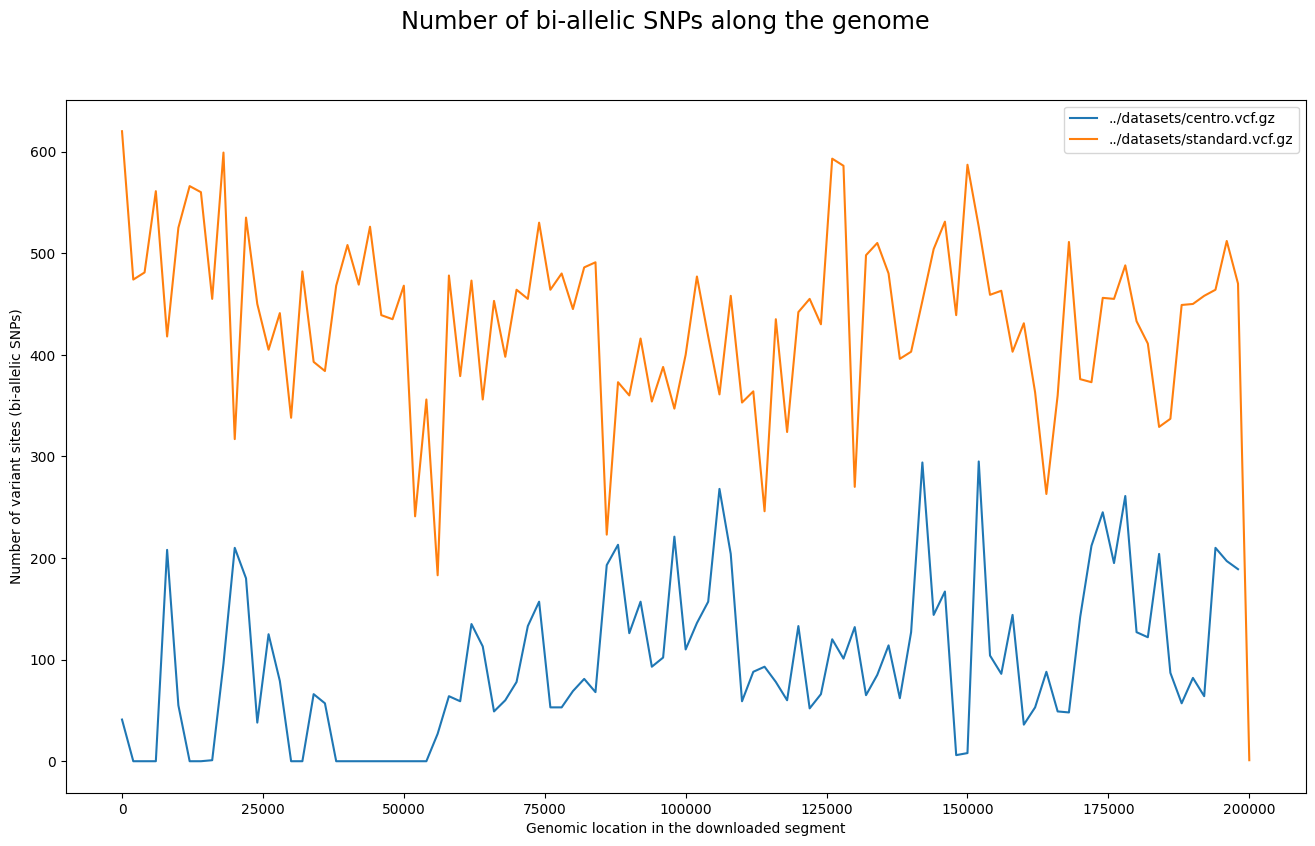

In [5]:
stats = {}
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in wins.items():
    stats[name] = apply_win_funs(nwins, {'sum': sum})
    x_lim = [i * size  for i in range(len(stats[name]))]
    ax.plot(x_lim, [x['sum'] for x in stats[name]], label=name)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('Number of variant sites (bi-allelic SNPs)')
fig.suptitle('Number of bi-allelic SNPs along the genome', fontsize='xx-large')

### 3. sample-level annotation
We will inspect mapping quality zero (refer to https://www.broadinstitute.org/gatk/guide/tooldocs/org_broadinstitute_gatk_tools_walkers_annotator_MappingQualityZeroBySample.php for details), which is a measure of how well sequences involved in calling this variant map clearly to this position. Note that there is also a MQ0 annotation at the variant level:

In [6]:
mq0_wins = {}
size = 5000
def get_sample(rec, annot, my_type):
    #We will ignore Nones
    res = []
    samples = rec.samples
    for sample in samples:
        if sample[annot] is None:
            continue
        res.append(my_type(sample[annot]))
    return res

for name in names:
    recs = vcf.Reader(filename=name)
    mq0_wins[name] = do_window(recs, size, functools.partial(get_sample, annot='MQ0', my_type=int))

### 4. print the median and the top 75 percent percentile for each window (in this case, with a size of 5,000):

C:\Users\TanQuangDuong\Anaconda3\envs\bioinformatics\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\TanQuangDuong\Anaconda3\envs\bioinformatics\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Distribution of MQ0 along the genome')

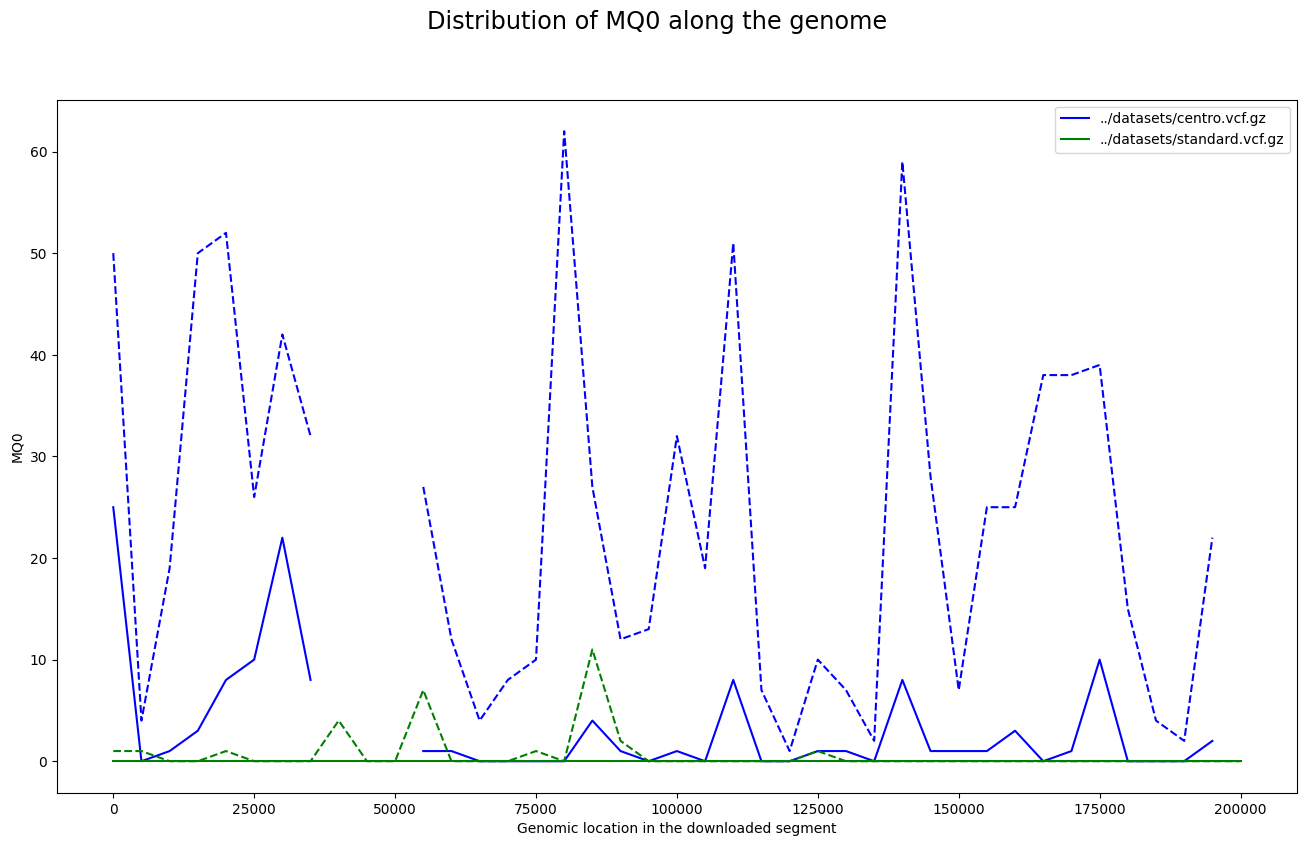

In [7]:
stats = {}
colors = ['b', 'g']
i = 0
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in mq0_wins.items():
    stats[name] = apply_win_funs(nwins, {'median': np.median, '75': functools.partial(np.percentile, q=95)})
    x_lim = [j * size  for j in range(len(stats[name]))]
    ax.plot(x_lim, [x['median'] for x in stats[name]], label=name, color=colors[i])
    ax.plot(x_lim, [x['75'] for x in stats[name]], '--', color=colors[i])
    i += 1
#ax.set_ylim(0, 40)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('MQ0')
fig.suptitle('Distribution of MQ0 along the genome', fontsize='xx-large')

### 5. compare heterozygosity with (DP), the sample-level annotation
we will plot the fraction of heterozygosity calls as a function of the Sample Read Depth (DP) for every SNP

In [11]:
def get_sample_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        for sample in rec.samples:
            try:
                v1 = f1(sample)
                v2 = f2(sample)
                if v1 is None or v2 is None:
                    continue  # We ignore Nones
                rel[(v1, v2)] += 1
                #careful with the size, floats: round?
            except:
                # This is outside the domain (typically None)
                pass
    return rel

In [12]:
rels = {}
for name in names:
    recs = vcf.Reader(filename=name)
    rels[name] = get_sample_relation(recs, lambda s: 1 if s.is_het else 0, lambda s: int(s['DP']))

Text(0.5, 0.98, 'Number of calls per depth and fraction of calls which are Hz')

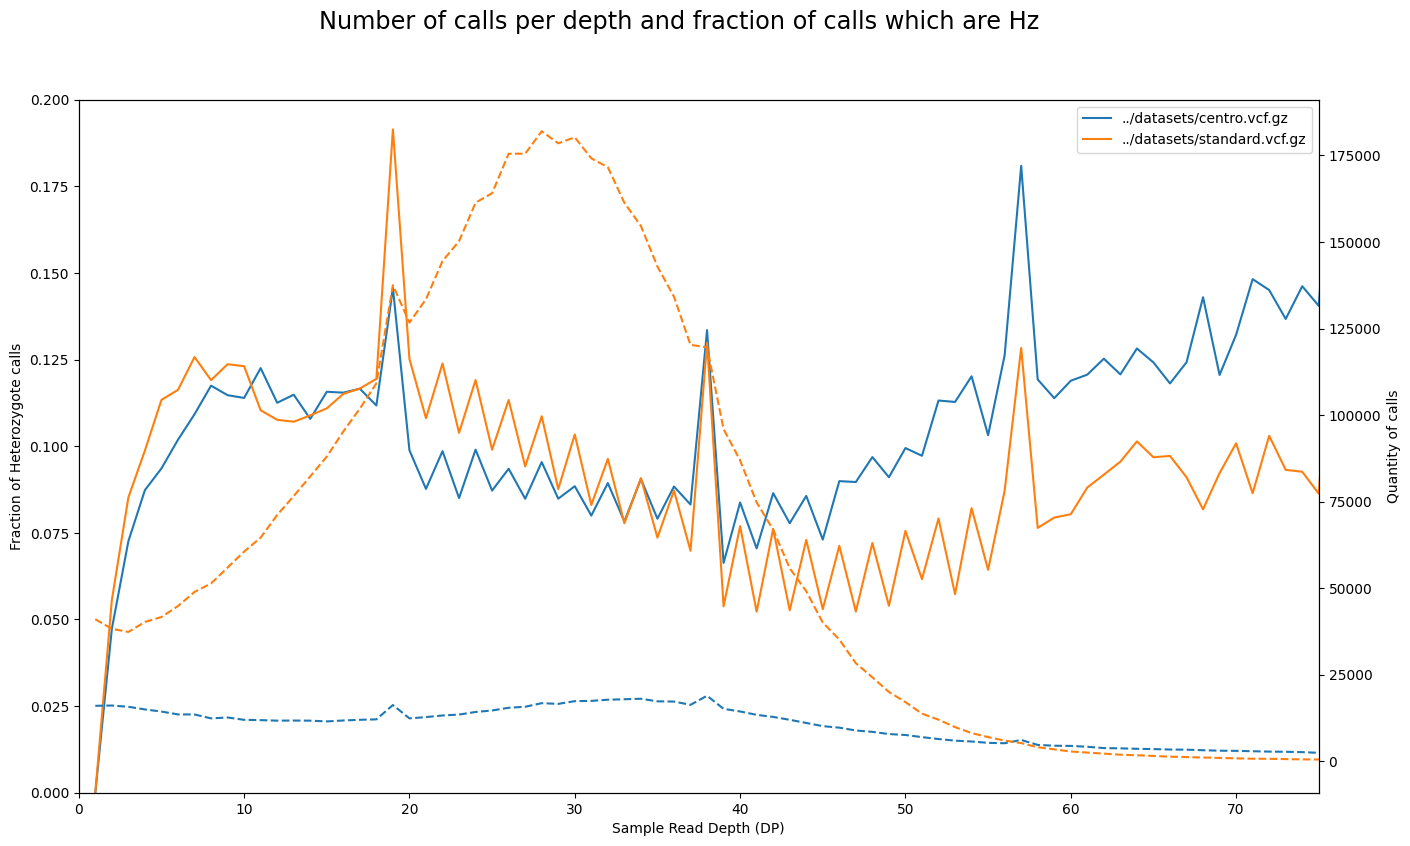

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))

def plot_hz_rel(dps, ax, ax2, name, rel):
    frac_hz = []
    cnt_dp = []
    for dp in dps:
        hz = 0.0
        cnt = 0

        for khz, kdp in rel.keys():
            if kdp != dp:
                continue
            cnt += rel[(khz, dp)]
            if khz == 1:
                hz += rel[(khz, dp)]
        frac_hz.append(hz / cnt)
        cnt_dp.append(cnt)
    ax.plot(dps, frac_hz, label=name)
    ax2.plot(dps, cnt_dp, '--', label=name)

ax2 = ax.twinx()
for name, rel in rels.items():
    dps = list(set([x[1] for x in rel.keys()]))
    dps.sort()
    plot_hz_rel(dps, ax, ax2, name, rel)
ax.set_xlim(0, 75)
ax.set_ylim(0, 0.2)
ax2.set_ylabel('Quantity of calls')
ax.set_ylabel('Fraction of Heterozygote calls')
ax.set_xlabel('Sample Read Depth (DP)')
ax.legend()
fig.suptitle('Number of calls per depth and fraction of calls which are Hz',
             fontsize='xx-large')

In [14]:
def get_variant_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        try:
            v1 = f1(rec)
            v2 = f2(rec)
            if v1 is None or v2 is None:
                continue  # We ignore Nones
            rel[(v1, v2)] += 1
            #careful with the size, floats: round?
        except:
            # This is outside the domain (typically None)
            pass
    return rel

In [15]:
accepted_eff = ['INTERGENIC', 'INTRON', 'NON_SYNONYMOUS_CODING', 'SYNONYMOUS_CODING']

def eff_to_int(rec):
    try:
        for annot in rec.INFO['EFF']:
            #We use the first annotation
            master_type = annot.split('(')[0]
            return accepted_eff.index(master_type)
    except ValueError:
        return len(accepted_eff)

In [16]:
eff_mq0s = {}
for name in names:
    recs = vcf.Reader(filename=name)
    eff_mq0s[name] = get_variant_relation(recs, lambda r: eff_to_int(r), lambda r: int(r.INFO['DP']))

Text(0.5, 0.98, 'Distribution of variant DP per SNP type')

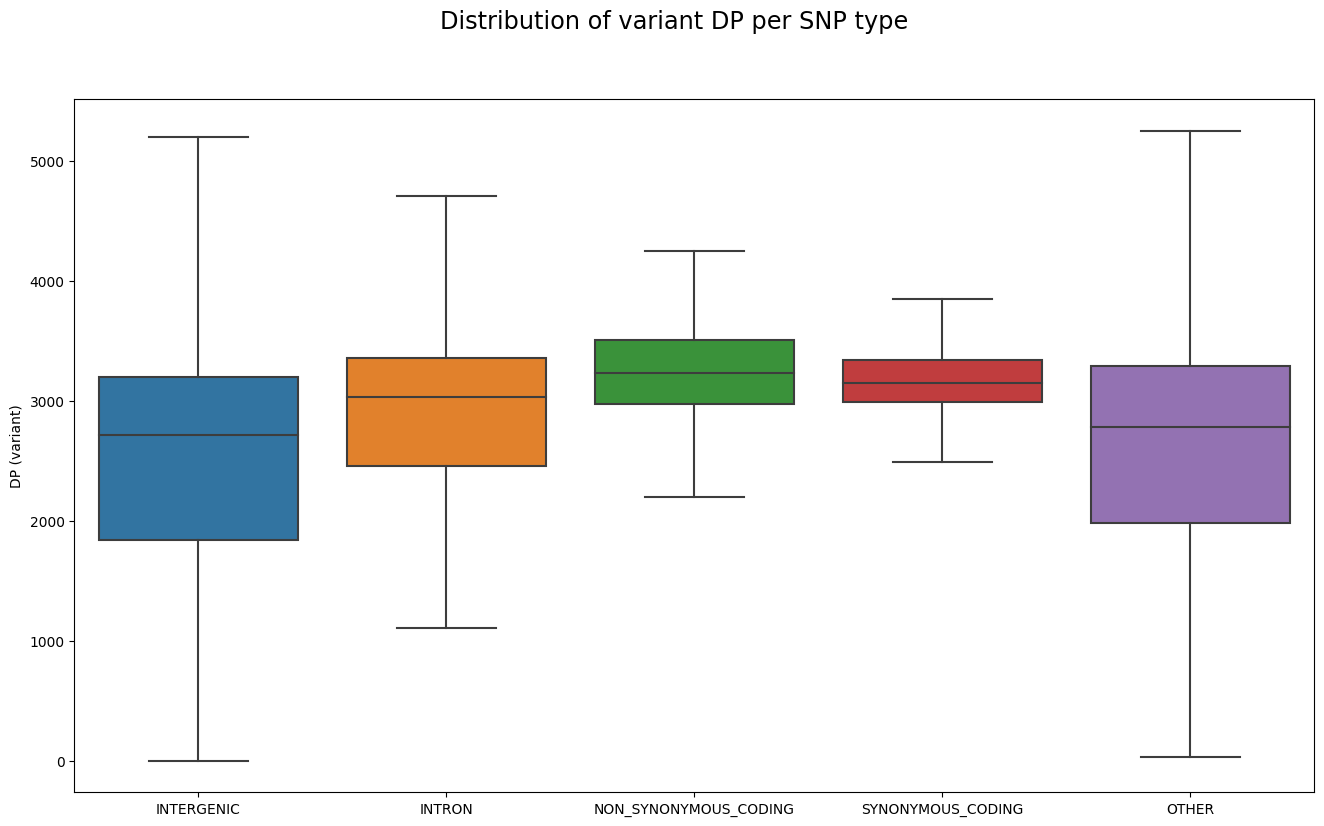

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
name = '../datasets/standard.vcf.gz'
bp_vals = [[] for x in range(len(accepted_eff) + 1)]
for k, cnt in eff_mq0s[name].items():
    my_eff, mq0 = k
    bp_vals[my_eff].extend([mq0] * cnt)
    #memory usage
#print(bp_vals[-2])
sns.boxplot(data=bp_vals, sym='', ax=ax)
ax.set_xticklabels(accepted_eff + ['OTHER'])
ax.set_ylabel('DP (variant)')
fig.suptitle('Distribution of variant DP per SNP type',
             fontsize='xx-large')

In [21]:
name = '../datasets/standard.vcf.gz'
recs = vcf.Reader(filename=name)
#mq0_dp = get_sample_relation(recs, lambda r: int(r['DP']), lambda r: int(r['GQ']))
mq0_dp = get_variant_relation(recs, lambda r: int(r.INFO['DP']) // 10, lambda r: int(float(r.INFO['MQ'])* 10))

In [23]:
max0 = 0
max1 = 0
min0 = float('inf')
min1 = float('inf')
for v0, v1 in mq0_dp.keys():
    if v0 > max0:
        max0 = v0
    if v1 > max1:
        max1 = v1
    if v0 < min0:
        min0 = v0
    if v1 < min1:
        min1 = v1
print(min0, min1, max0, max1)
min1 = 300
max1 = 600
max0 = 400
mat = np.zeros((max0 + 1, max1 - min1 + 1), dtype="int")
for k, cnt in mq0_dp.items():
    v0, v1 = k
    if v0 > max0:
        continue
    if v1 < min1 or v1 > max1:
        continue
    mat[v0, v1 - min1] = cnt

0 7 688 589


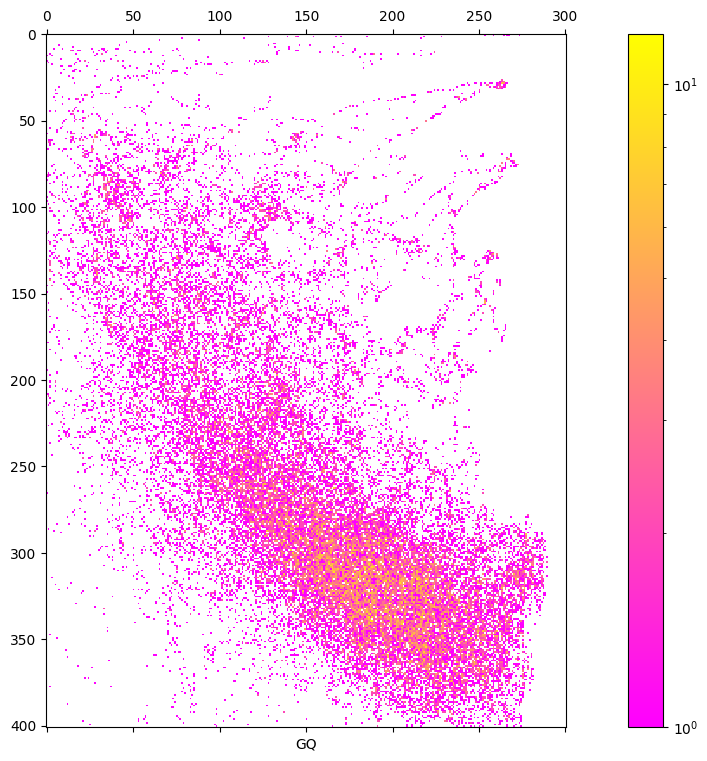

In [24]:
from matplotlib import colors
fig, ax = plt.subplots(figsize=(16,9))
mtax = ax.matshow(mat, norm=colors.LogNorm(), cmap=plt.get_cmap('spring'))
ax.set_xlabel('DP')
ax.set_xlabel('GQ')
cbar = fig.colorbar(mtax, orientation='vertical')